## Import essential packages

We'll now import the packages required to execute the project properly.
These are Python packages/modules that are often used for different purposes in deep learning, data manipulation, visualization, and evaluation.

In [11]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import vision_transformer
from torchvision.transforms import transforms
from tqdm import tqdm
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the dataset and resize the images

In the beginning, we have two possibilities for retrieving the dataset: upload it from our local files and give the right path, or use Kaggle to retrieve it. Once the dataset is accessible, we begin image preprocessing. 
We start by defining transformations for preprocessing the images. These steps involve scaling each image to a standard size of 180 × 180 pixels and applying normalization. Normalization sets the pixel values to have a mean of 0.5 and a standard deviation of 0.5 in each color channel, guaranteeing similar data qualities.

In [13]:
import os
import torchvision.datasets as datasets

# Define the path to your dataset root directory
root_dataset = '/content/drive/MyDrive/archive/Data'

# Load the dataset using ImageFolder
satellite_dataset = datasets.ImageFolder(root=root_dataset)

# Print class names (genres) and corresponding labels
print("Class names and labels:")
print(satellite_dataset.classes)

# Print the number of images in each class
print("\nNumber of images in each class :")
for class_name, class_count in satellite_dataset.class_to_idx.items():
    print(f"{class_name}: {len(os.listdir(os.path.join(root_dataset, class_name)))} images")

Class names and labels:
['cloudy', 'desert', 'green_area', 'water']

Number of images in each class :
cloudy: 1500 images
desert: 1131 images
green_area: 1500 images
water: 1500 images


In [14]:
#Resize the images to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Load the dataset

dataset = datasets.ImageFolder(root='/content/drive/MyDrive/archive/Data', transform=transform)
# Define the sizes of each split

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset randomly
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("# training samples={}, validation samples={}, test samples={}".format(len(train_data), len(val_data), len(test_data)))

# training samples=3941, validation samples=1126, test samples=564


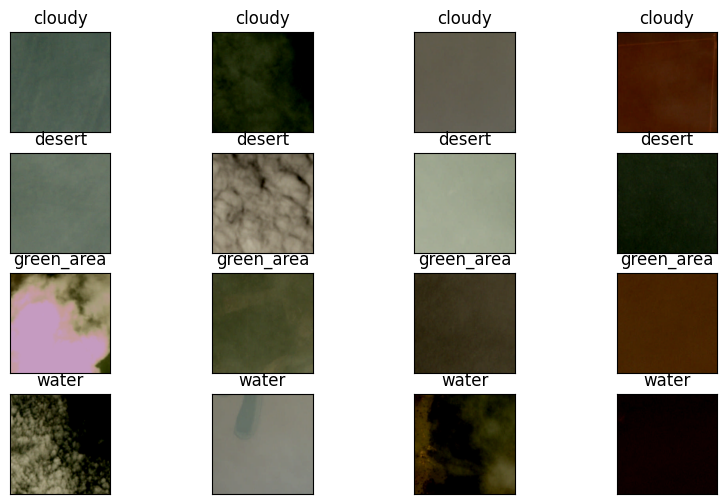

In [16]:
# Assuming train_data is your DataLoader object
fig = plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
fig.tight_layout()

class_names = ['cloudy', 'desert', 'green_area', 'water']

num_images_per_genre = 4 # Display 2 images for each satellite images type

class_indices = {class_name: [] for class_name in class_names}

# Collect indices of images for each classes
for i, (_, label) in enumerate(train_data):
    class_name = class_names[label]
    if len(class_indices[class_name]) < num_images_per_genre:
        class_indices[class_name].append(i)
    if all(len(indices) == num_images_per_genre for indices in class_indices.values()):
        break

# Display images
for i, class_name in enumerate(class_names):
    for j, index in enumerate(class_indices[class_name]):
        img, _ = train_data.dataset[index]
        img = img.permute(1, 2, 0)  # Rearrange dimensions from (3, 180, 180) to (180, 180, 3)

        t = fig.add_subplot(len(class_names), num_images_per_genre, i*num_images_per_genre + j + 1)
        t.set_title(class_name)  # Set title as genre name
        t.axes.get_xaxis().set_visible(False)
        t.axes.get_yaxis().set_visible(False)
        plt.imshow(img)

plt.show()

In [17]:
class CustomDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=None,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None):
        super(CustomDataLoader, self).__init__(
            dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler,
            batch_sampler=batch_sampler, num_workers=num_workers,
            collate_fn=collate_fn, pin_memory=pin_memory, drop_last=drop_last,
            timeout=timeout, worker_init_fn=worker_init_fn
        )

### Define data loaders

We set up the data loaders.  
Every loader is designed to function with a certain subset of the dataset, whether for testing, validation, or training. 
While the 'val_loader' and 'test_loader' use the same batch size, they do not shuffle their datasets, which is a usual practice for validation and test data to maintain consistency throughout assessment. The 'train_loader' is set to a batch size of 32 and supports data shuffling to introduce unpredictability during training epochs. 
No additional processes are created for the purpose of loading data, as evidenced by the option 'num_workers' being set to 0 across all loaders. 
Configuring these loaders improves efficiency and makes it easier to train and evaluate models on various subsets.

In [18]:
# setting up data loaders for training, validation, and testing datasets
batch_size=32
train_loader=CustomDataLoader(train_data,batch_size=batch_size,num_workers=2, shuffle=True)
val_loader=CustomDataLoader(val_data,batch_size=batch_size,num_workers=2,shuffle=False)
test_loader=CustomDataLoader(test_data,batch_size=batch_size,num_workers=2,shuffle=False)

In [19]:
pip install timm

## 4. Transformers
This code defines a Vision Transformer (ViT) model for image classification using PyTorch and Timm library. The ViT model is initialized with a pre-trained "vit_base_patch16_224" architecture and a linear layer for classification. It's then trained using a provided training dataset and validated using a validation dataset, with the Adam optimizer and Cross-Entropy Loss function. The training loop iterates over a specified number of epochs, evaluating the model's performance on both training and validation sets after each epoch. Finally, the trained model is evaluated on a test set to assess its performance in terms of loss and accuracy.

In [20]:
import timm
# Define the ViT model
# Define the ViT model
class ViTForImageClassification(nn.Module):
    def __init__(self, num_classes):
        super(ViTForImageClassification, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the ViT model
num_classes = len(satellite_dataset.classes)
model = ViTForImageClassification(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f}")

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct_preds / total_preds
    return val_loss, val_accuracy

# Train the model
num_epochs = 10
train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)

# Evaluate on test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Train Loss: 0.2260


Val Loss: 0.0799 | Val Accuracy: 0.9751


Train Loss: 0.0870


Val Loss: 0.0521 | Val Accuracy: 0.9831


Train Loss: 0.0483


Val Loss: 0.0421 | Val Accuracy: 0.9885


Train Loss: 0.0500


Val Loss: 0.2622 | Val Accuracy: 0.9174


Train Loss: 0.0935


Val Loss: 0.0714 | Val Accuracy: 0.9734


Train Loss: 0.0356


Val Loss: 0.0228 | Val Accuracy: 0.9929


Train Loss: 0.0456


Val Loss: 0.1043 | Val Accuracy: 0.9698


Train Loss: 0.0359


Val Loss: 0.0326 | Val Accuracy: 0.9911


Train Loss: 0.0286


Val Loss: 0.3943 | Val Accuracy: 0.9227


Train Loss: 0.0655


Val Loss: 0.0672 | Val Accuracy: 0.9822
Test Loss: 0.0402 | Test Accuracy: 0.9876
